## House Weather Data Analysis

Work out what to do with the data I'm capturing and learn Pandas and Jupyter in the process. Possibly also (re)learn some statistics.

The top level github project for this [is here](https://github.com/users/oisinmulvihill/projects/3).


In [408]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [409]:
# Use the first column (timestamp) as the index
df = pd.read_csv(
    './data/indoor_sample.csv', 
    index_col=0,
    names=["timestamp", "mac", "type", "t", "h", "p", "g"],
    parse_dates=True
)

In [410]:
df.head()

,mac,type,t,h,p,g
timestamp,,,,,,
2020-06-19 22:25:18.725918,90:A2:DA:00:61:58,bme680,2310,44785,101504,311113
2020-06-19 22:26:26.303364,90:A2:DA:00:61:58,bme680,2307,48250,101561,360705
2020-06-19 22:26:33.113012,90:A2:DA:00:61:58,bme680,2310,47944,101642,274425
2020-06-20 00:09:19.839996,90:A2:DA:00:61:58,bme680,2406,46192,101799,212558
2020-06-20 00:14:19.937346,90:A2:DA:00:61:58,bme680,2405,45726,101799,155522


In [411]:
df.dtypes

mac     object
type    object
t        int64
h        int64
p        int64
g        int64
dtype: object

### The columns are what the indoor_sampler sends

See [sample server API](https://github.com/oisinmulvihill/sample_server#rest-api) endpoint for more details.

- t: temperature (-40°C-85°C), integer, needs converting to decimal by /100
- h: humidity (10%-90%, in 0°C-65°C), integer, convert to decimal by /1000
- p: pressure (300hPa-1100hPa, in 0°C-65°C) integer, covert to decimal by /100
- g: gas sensor resistance reading (50Ω <-> 50kΩ), integer, (not sure about conversion)

Details for [BME680 sensor](https://community.bosch-sensortec.com/t5/Knowledge-base/BME680-Sensor-Data-Interpretation/ta-p/8713)

**IAQ Notes**

Rather annoyingly the Indoor Air Quality Score (IAQ) is generated using the manufacturers binary library rather than being open. I will come back around on this later. Some links to aid me possibly [get around using a close source binary](https://github.com/G6EJD/BME680-Example) or [Pimiori's Python lib](https://github.com/pimoroni/bme680-python/blob/master/examples/indoor-air-quality.py). Alternatively I could just use the [library](https://community.bosch-sensortec.com/t5/Question-and-answers/How-do-I-convert-BME680-gas-resistance-to-IAQ/qaq-p/9050), compile it into my Arduino Ethernet (not sure it will fit) and move on with my life.



In [412]:
df['temperature'] = df.t / 100
df['humidity'] = df.h / 1000
df['pressure'] = df.p / 100
df['gas'] = df.g

In [413]:
df.head()

,mac,type,t,h,p,g,temperature,humidity,pressure,gas
timestamp,,,,,,,,,,
2020-06-19 22:25:18.725918,90:A2:DA:00:61:58,bme680,2310,44785,101504,311113,23.10,44.785,1015.04,311113
2020-06-19 22:26:26.303364,90:A2:DA:00:61:58,bme680,2307,48250,101561,360705,23.07,48.250,1015.61,360705
2020-06-19 22:26:33.113012,90:A2:DA:00:61:58,bme680,2310,47944,101642,274425,23.10,47.944,1016.42,274425
2020-06-20 00:09:19.839996,90:A2:DA:00:61:58,bme680,2406,46192,101799,212558,24.06,46.192,1017.99,212558
2020-06-20 00:14:19.937346,90:A2:DA:00:61:58,bme680,2405,45726,101799,155522,24.05,45.726,1017.99,155522


In [414]:
# Group by date
group_by_date = df.loc[:, ['temperature', 'humidity', 'pressure', 'gas']].groupby(df.index.date)

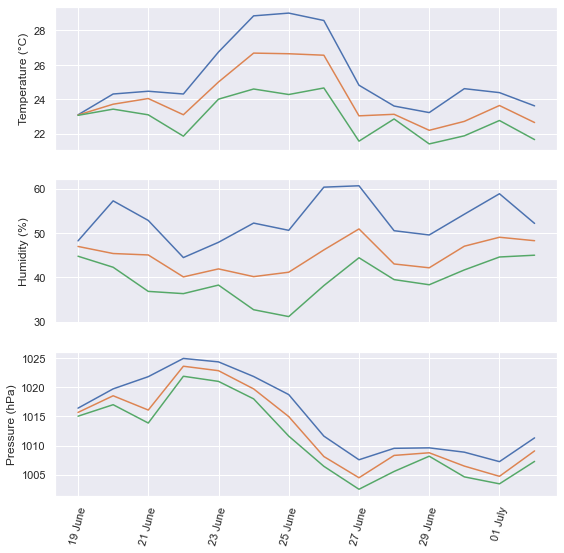

In [426]:
from matplotlib.dates import DateFormatter

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

max = group_by_date.max()
mean = group_by_date.mean()
min = group_by_date.min()

fig = plt.figure(figsize=(9, 9))

temp, humid, press = fig.subplots(3, 1)
temp.set_ylabel('Temperature (°C)')
plt.setp(temp.get_xticklabels(), visible=False)

humid.set_ylabel('Humidity (%)')
# humid.yaxis.label.set_color('green')
# humid.tick_params(axis='y', colors='green')
plt.setp(humid.get_xticklabels(), visible=False)

press.set_ylabel('Pressure (hPa)')
# press.yaxis.label.set_color('blue')
# press.tick_params(axis='y', colors='blue')
# Use the pressure yticks label for all now the others are hidden.
press.tick_params(axis='x', rotation=75)
date_form = DateFormatter("%d %B") # %B: month name, %d: date as number
press.xaxis.set_major_formatter(date_form)

temp.plot(mean.index, max.temperature, label="Max")
temp.plot(mean.index, mean.temperature, label="Avg")
temp.plot(mean.index, min.temperature, label="Min")

humid.plot(mean.index, max.humidity, label="Max")
humid.plot(mean.index, mean.humidity, label="Avg")
humid.plot(mean.index, min.humidity, label="Min")

press.plot(mean.index, max.pressure, label="Max")
press.plot(mean.index, mean.pressure, label="Avg")
press.plot(mean.index, min.pressure, label="Min")


